In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt
import yaml

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [ ]:
exp_id = '13-resnet_bn_dr_0.1'
datadir = '/data/stephan/WeatherBench/2.8125deg/'
# datadir = '/data/stephan/WeatherBench/5.625deg/'
model_save_dir = '/home/rasp/data/myWeatherBench/predictions/saved_models/'
pred_save_dir = '/home/rasp/data/myWeatherBench/predictions/'
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 'constants': ['lsm','orography','lat2d']}
output_vars = ['z_500', 't_850']
filters = [128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72
lr = 0.5e-4
early_stopping_patience = 10
reduce_lr_patience = 5
data_subsample = 2
norm_subsample = 30000
bn_position = 'post'
use_bias = True
dropout = 0.1

batch_size = 32
nt_in = 1
l2 = 0
skip = True

In [33]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [34]:
ds_train = ds.sel(time=slice('2015', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [35]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_valid = DataGenerator(
    ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 13:49:04.245867
DG normalize 13:49:04.272392
DG load 13:49:18.132124
Loading data into RAM
DG done 13:49:31.354134
DG start 13:49:31.354954
DG normalize 13:49:31.377664
DG load 13:49:31.387208
Loading data into RAM
DG done 13:49:50.233831
DG start 13:49:50.234824
DG normalize 13:49:50.260243
DG load 13:49:50.270765
Loading data into RAM
DG done 13:50:19.196560


In [8]:
# 2.8
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 15)>
 array([ 1.15201759e+05,  5.39444590e+04,  1.37032833e+04,  2.19051652e+02,
         2.52386592e+02,  2.73755411e+02,  1.48783322e+01,  6.67773649e+00,
         1.19053692e+00,  3.22724382e-01,  1.21706842e-01, -2.72158433e-01,
         3.34394237e-01,  3.78530841e+02,  0.00000000e+00])
 Coordinates:
   * level        (level) int64 200 500 850 200 500 850 200 ... 200 500 850 1 1 1
     level_names  (level) <U9 'z_200' 'z_500' 'z_850' ... 'orography' 'lat2d',
 <xarray.DataArray 'z' (level: 15)>
 array([5.58323710e+03, 3.23706845e+03, 1.36864250e+03, 5.55358263e+00,
        1.33121151e+01, 1.43570794e+01, 1.89776323e+01, 1.29311825e+01,
        8.35005218e+00, 1.27525757e+01, 9.89100792e+00, 6.91514649e+00,
        4.58128884e-01, 8.49150264e+02, 5.19551809e+01])
 Coordinates:
   * level        (level) int64 200 500 850 200 500 850 200 ... 200 500 850 1 1 1
     level_names  (level) <U9 'z_200' 'z_500' 'z_850' ... 'orography' 'lat2d')

In [9]:
# 5.6
# dg_train.mean, dg_train.std

In [82]:
model = build_resnet(
    filters, kernels, input_shape=(
        len(dg_train.data.lat), len(dg_train.data.lon), len(dg_train.data.level) * nt_in
    ),
    bn_position=bn_position, use_bias=use_bias, l2=l2, skip=skip,
    dropout=dropout
)

In [127]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 128, 15) 0                                            
__________________________________________________________________________________________________
periodic_conv2d_112 (PeriodicCo (None, 64, 128, 128) 94208       input_8[0][0]                    
__________________________________________________________________________________________________
activation_105 (Activation)     (None, 64, 128, 128) 0           periodic_conv2d_112[0][0]        
__________________________________________________________________________________________________
batch_normalization_105 (BatchN (None, 64, 128, 128) 512         activation_105[0][0]             
____________________________________________________________________________________________

In [38]:
model.compile(keras.optimizers.Adam(lr), 'mse')

In [39]:
history = model.fit(dg_train, epochs=1, validation_data=dg_valid)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 136 steps, validate for 273 steps
136/136 [==============================] - 86s 631ms/step - loss: 4.7859 - val_loss: 0.9650


## With pretraining

In [83]:
model = build_resnet(
    filters, kernels, input_shape=(
        len(dg_train.data.lat), len(dg_train.data.lon), len(dg_train.data.level) * nt_in
    ),
    bn_position=bn_position, use_bias=use_bias, l2=l2, skip=skip,
    dropout=dropout
)

In [102]:
len(model.layers)

69

In [88]:
pre_model = keras.models.load_model(f'{model_save_dir}/{exp_id}.h5', 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D})

In [103]:
len(pre_model.layers)

69

In [92]:
pre_model.evaluate(dg_valid)

  ...
    to  
  ['...']
273/273 [==============================] - 27s 97ms/step - loss: 0.1478


0.14779005377065568

In [123]:
n = 'periodic_conv2d_15'

In [126]:
for i, l in enumerate(pre_model.layers):
    model.layers[i].set_weights(l.get_weights())
    if l.name == n: break

In [128]:
last_trainable_layer = 'periodic_conv2d_122'

In [132]:
l.trainable

False

In [133]:
for l in model.layers:
    l.trainable = False
    if l.name == last_trainable_layer: break

In [134]:
for l in model.layers:
    print(l.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [109]:
model.compile('adam', 'mse')

In [110]:
model.evaluate(dg_valid)

  ...
    to  
  ['...']
273/273 [==============================] - 27s 100ms/step - loss: 0.1478


0.14779005377065568

In [100]:
w = l.get_weights()

In [101]:
l.set_weights(w)

In [96]:
len(l.weights)

2

In [84]:
weights = model.get_weights()

In [87]:
len(model.layers)

69

In [86]:
len(weights)

92

In [69]:
model = keras.models.load_model(f'{model_save_dir}/{exp_id}.h5', 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D})

In [70]:
model.layers[1].conv.use_bias

True

In [71]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 15)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  94208       input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         re_lu[0][0]                      
______________________________________________________________________________________________

In [12]:
history = model.fit(dg_train, epochs=1, validation_data=dg_valid)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 272 steps, validate for 545 steps
272/272 [==============================] - 88s 325ms/step - loss: 0.1158 - val_loss: 0.1122


## Evaluation

In [13]:
valdir = '/data/stephan/WeatherBench/5.625deg/'
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z')
t850_valid = load_test_data(f'{valdir}temperature_850', 't')

In [14]:
lr_preds = xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [15]:
preds = create_predictions(model, dg_test)

In [16]:
preds

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 17448)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -88.59 -85.78 -82.97 -80.16 ... 82.97 85.78 88.59
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    t        (time, lat, lon) float64 253.5 253.7 253.8 ... 255.6 255.6 255.5
    z        (time, lat, lon) float64 5.099e+04 5.09e+04 ... 4.916e+04 4.915e+04

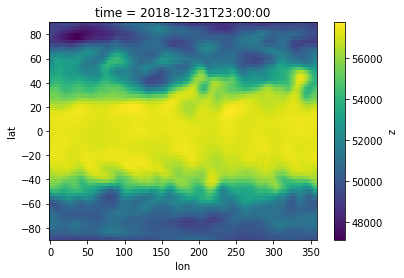

In [17]:
preds.isel(time=-1).z.plot()

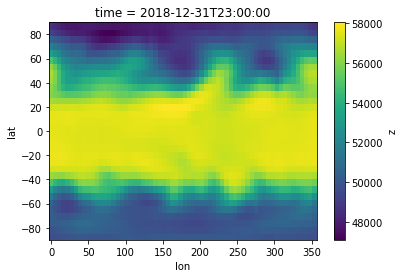

In [18]:
lr_preds.isel(time=-1).z.plot()

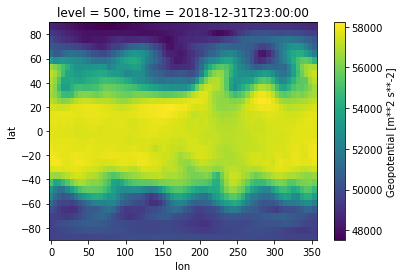

In [19]:
z500_valid.isel(time=-1).plot()

In [20]:
from src.regrid import regrid

In [21]:
hr_preds = regrid(preds, ddeg_out=5.625)

Create weight file: bilinear_64x128_32x64_peri.nc
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable t as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable

In [23]:
compute_weighted_rmse(hr_preds.z, z500_valid).load()

<xarray.DataArray 'z_rmse' ()>
array(1015.60482197)
Coordinates:
    level    int32 500

In [24]:
compute_weighted_rmse(hr_preds.t, t850_valid).load()

<xarray.DataArray 't_rmse' ()>
array(3.98893589)
Coordinates:
    level    int32 850

## Fix weight loading issue

In [76]:
model = build_resnet(
    filters, kernels, input_shape=(
        len(dg_train.data.lat), len(dg_train.data.lon), len(dg_train.data.level) * nt_in
    ),
    bn_position=bn_position, use_bias=0, l2=l2, skip=skip,
    dropout=dropout
)

In [77]:
model.count_params()

2168450

In [75]:
model.count_params()

2168450

In [73]:
model.count_params()

2170370

In [63]:
model.load_weights(f'{model_save_dir}/{exp_id}_weights.h5')

In [64]:
l = model.layers[1].conv.use_bias

In [68]:
l.conv.use_bias

True

In [48]:
len(l.weights)

1

In [50]:
import h5py
f = h5py.File(f'{model_save_dir}/{exp_id}_weights.h5', 'r')
print(list(f.keys()))

['add', 'add_1', 'add_2', 'add_3', 'add_4', 'add_5', 'add_6', 'batch_normalization', 'batch_normalization_1', 'batch_normalization_10', 'batch_normalization_11', 'batch_normalization_12', 'batch_normalization_13', 'batch_normalization_14', 'batch_normalization_2', 'batch_normalization_3', 'batch_normalization_4', 'batch_normalization_5', 'batch_normalization_6', 'batch_normalization_7', 'batch_normalization_8', 'batch_normalization_9', 'dropout', 'dropout_1', 'dropout_10', 'dropout_11', 'dropout_12', 'dropout_13', 'dropout_14', 'dropout_2', 'dropout_3', 'dropout_4', 'dropout_5', 'dropout_6', 'dropout_7', 'dropout_8', 'dropout_9', 'input_1', 'periodic_conv2d', 'periodic_conv2d_1', 'periodic_conv2d_10', 'periodic_conv2d_11', 'periodic_conv2d_12', 'periodic_conv2d_13', 'periodic_conv2d_14', 'periodic_conv2d_15', 'periodic_conv2d_2', 'periodic_conv2d_3', 'periodic_conv2d_4', 'periodic_conv2d_5', 'periodic_conv2d_6', 'periodic_conv2d_7', 'periodic_conv2d_8', 'periodic_conv2d_9', 're_lu', 'r

In [59]:
list(f['periodic_conv2d_2']['periodic_conv2d_2']['conv2d_2']
.keys())

['bias:0', 'kernel:0']

In [ ]:
import h5py
f = h5py.File(f'{model_save_dir}/{exp_id}_weights.h5', 'r')
print(list(f.keys())
# will get a list of layer names which you can use as index
d = f['dense']['dense_1']['kernel:0']
# <HDF5 dataset "kernel:0": shape (128, 1), type "<f4">
d.shape == (128, 1)
d[0] == array([-0.14390108], dtype=float32)